## ⏱️ **GRID SEARCH COMPUTATION TIME TRACKING**

### 🎯 **TUJUAN PENELITIAN EFISIENSI KOMPUTASIONAL**

Sesuai dengan rumusan masalah penelitian:

> **"Bagaimana perbandingan efisiensi komputasional waktu tuning, sumber daya yang dibutuhkan antara metode-metode Hyperparameter Tuning yang diterapkan pada model Transfer Learning untuk klasifikasi citra batik?"**

### 📊 **METRICS YANG DITRACK UNTUK GRID SEARCH:**

1. **⏱️ Total Waktu Komputasi**: Waktu total dari awal sampai selesai
2. **🔍 Waktu Grid Search Tuning**: Waktu yang dibutuhkan untuk hyperparameter tuning
3. **📊 Waktu Evaluasi**: Waktu yang dibutuhkan untuk evaluasi model
4. **💾 Memory Usage**: Penggunaan memori selama proses
5. **🖥️ CPU Usage**: Penggunaan CPU selama proses
6. **📅 Timestamp**: Waktu mulai dan selesai

### 🔧 **IMPLEMENTASI:**

- **Time Tracking**: Tracking waktu Grid Search tuning
- **Resource Monitoring**: Monitoring penggunaan sistem
- **JSON Export**: Menyimpan hasil timing untuk analisis
- **Real-time Logging**: Log progress selama proses

### 📈 **MANFAAT:**

1. **Perbandingan Efisiensi**: Dapat membandingkan waktu komputasi antar metode
2. **Resource Optimization**: Mengetahui penggunaan resource yang optimal
3. **Cost Analysis**: Analisis biaya komputasi untuk penelitian
4. **Reproducibility**: Memastikan hasil dapat direproduksi dengan timing yang konsisten

### 🎯 **SESUAI TUJUAN PENELITIAN:**

> **"Menghasilkan data perbandingan terukur mengenai efisiensi komputasional meliputi waktu tuning dan estimasi kebutuhan sumber daya dari penerapan ketiga metode Hyperparameter Tuning tersebut pada model Transfer Learning MobileNetV2 untuk tugas klasifikasi citra batik."**


In [8]:
# =========== GRID SEARCH TIME TRACKING ===========
import time
import psutil
import os
from datetime import datetime
import json

# Start tracking
grid_search_start_time = time.time()
grid_search_start_datetime = datetime.now()
print(f"⏱️  Mulai tracking waktu komputasi: Grid Search")
print(f"📅 Waktu mulai: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")


⏱️  Mulai tracking waktu komputasi: Grid Search
📅 Waktu mulai: 2025-07-31 14:30:16


# GridSearch Hyperparameter Tuning for Batik Classification

This notebook implements GridSearch hyperparameter tuning for the batik classification model using Keras Tuner.

In [6]:
# Standard library
import os
import random
import shutil
from collections import Counter, defaultdict
from sklearn.model_selection import train_test_split

# Third-party packages
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import compute_class_weight

# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from keras.layers import TFSMLayer
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    GlobalAveragePooling2D,
    Dense,
    Dropout
)
from tensorflow.keras.applications import InceptionV3, MobileNetV2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import (
    ImageDataGenerator,
    load_img,
    img_to_array
)
from tensorflow.keras.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    ReduceLROnPlateau,
    Callback
)

# Hilangkan warning TensorFlow dan Python
import warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.filterwarnings('ignore')

In [7]:
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    print("✅ TensorFlow mendeteksi GPU (CUDA):")
    for gpu in gpus:
        print(f"  - {gpu.name}")
else:
    print("⚠️ TensorFlow TIDAK mendeteksi GPU. Model berjalan di CPU.")

✅ TensorFlow mendeteksi GPU (CUDA):
  - /physical_device:GPU:0


In [8]:
train_dir = os.path.join('../../../../data/splits/dataset_split', 'train')
val_dir = os.path.join('../../../../data/splits/dataset_split', 'val')
test_dir = os.path.join('../../../../data/splits/dataset_split', 'test')

# Fungsi untuk menghitung jumlah file per kelas dalam sebuah direktori
def count_images_per_class(directory):
    return {
        cls: len(os.listdir(os.path.join(directory, cls)))
        for cls in os.listdir(directory)
        if os.path.isdir(os.path.join(directory, cls))
    }
    
# Hitung jumlah gambar per kelas
train_counts = count_images_per_class(train_dir)
val_counts = count_images_per_class(val_dir)
test_counts = count_images_per_class(test_dir)
total_gambar = sum(train_counts.values()) + sum(val_counts.values()) + sum(test_counts.values())

# Gabungkan ke dalam DataFrame
df = pd.DataFrame({
    'Train': train_counts,
    'Validation': val_counts,
    'Test': test_counts
}).T.fillna(0).astype(int).T  # Transpose agar kelas sebagai indeks


print(f"Total gambar : {total_gambar}")
# Tampilkan sebagai tabel
print("\nSebaran Data per Kelas:")
print(df)

Total gambar : 1080

Sebaran Data per Kelas:
                  Train  Validation  Test
Sekar Pijetan        12           3     3
Sekar Pacar          12           3     3
Gedhangan            12           3     3
Sekar Keben          12           3     3
Sekar Jali           12           3     3
Mawur                12           3     3
Sekar Duren          12           3     3
Sekar Dlima          12           3     3
Jayakirana           12           3     3
Cinde Wilis          12           3     3
Sekar Blimbing       12           3     3
Sekar Ketongkeng     12           3     3
Sekar Kemuning       12           3     3
Sekar Srengenge      12           3     3
Sekar Tebu           12           3     3
Sekar Kepel          12           3     3
Sekar Lintang        12           3     3
Sekar Kenthang       12           3     3
Sekar Pala           12           3     3
Sekar Mlathi         12           3     3
Sekar Randhu         12           3     3
Jayakusuma           12        

In [9]:
IMG_SIZE = (160, 160)
BATCH_SIZE = 4
SEED = 42
NUM_CLASSES = 60

In [10]:
train_datagen = ImageDataGenerator(
    rescale=1./255,                # Normalisasi piksel gambar dari 0-255 menjadi 0-1
    rotation_range=20,            # Rotasi gambar acak hingga 20 derajat
    zoom_range=0.2,               # Zoom acak hingga 20% untuk mensimulasikan perbedaan jarak
    width_shift_range=0.2,        # Geser gambar secara horizontal hingga 20% lebar gambar
    height_shift_range=0.2,       # Geser gambar secara vertikal hingga 20% tinggi gambar
    shear_range=0.15,             # Distorsi gambar secara miring (shear)
    horizontal_flip=True,         # Membalik gambar secara horizontal (misalnya daun kiri dan kanan)
    brightness_range=[0.8, 1.2],  # Variasi pencahayaan gambar
    fill_mode='nearest'           # Isi area kosong hasil transformasi dengan piksel terdekat
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [11]:
train_generator = train_datagen.flow_from_directory(
    train_dir,  # Folder berisi data latih
    target_size = IMG_SIZE,         # Ukuran gambar diubah menjadi 224x224
    batch_size = BATCH_SIZE,        # Jumlah gambar per batch
    class_mode = 'categorical',       # Label dalam format one-hot (karena klasifikasi multi-kelas)
    shuffle = True,                   # Acak data untuk melatih model dengan lebih baik
    seed = SEED                         # Seed untuk konsistensi hasil saat diacak
)


val_generator = val_datagen.flow_from_directory(
    val_dir,  # Folder validasi
    target_size = IMG_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    shuffle = False,                  # Tidak diacak agar evaluasi konsisten
    seed = 42
)

test_generator = test_datagen.flow_from_directory(
    test_dir,   # Folder pengujian
    target_size = IMG_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    shuffle = False,                  # Tidak diacak agar prediksi bisa dibandingkan langsung
    seed = 42
)

Found 720 images belonging to 60 classes.
Found 180 images belonging to 60 classes.
Found 180 images belonging to 60 classes.


In [15]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, GlobalAveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from sklearn.utils.class_weight import compute_class_weight
from kerastuner.tuners import GridSearch
from kerastuner.engine.hyperparameters import HyperParameters
import os
import time

# Callback untuk progress log
class TuningCallback(tf.keras.callbacks.Callback):
    def __init__(self, tuner_name):
        super().__init__()
        self.tuner_name = tuner_name
    
    def on_epoch_end(self, epoch, logs=None):
        metrics_str = " | ".join([f"{k}: {v:.4f}" for k, v in logs.items()])
        print(f"✨ {self.tuner_name} - Epoch {epoch + 1} — {metrics_str}")

# =========== MODEL BUILDER UNTUK HYPERPARAMETER TUNING ===========
def build_model(hp):
    # Load pre-trained MobileNetV2 dengan freezing
    base_model = MobileNetV2(
        input_shape=(*IMG_SIZE, 3),
        include_top=False,
        weights='imagenet'
    )
    
    # Freeze semua layer pada base model
    base_model.trainable = False
    
    model = Sequential()
    model.add(base_model)
    
    # Tambahkan ConvLayer (opsional)
    if hp.Boolean('add_conv_layer', default=True):
        filters = hp.Choice('conv_filters', values=[64, 128], default=64)
        model.add(Conv2D(filters, (3, 3), activation='relu', padding='same'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # GlobalAveragePooling2D untuk flatten feature map
    model.add(GlobalAveragePooling2D())
    
    # Dense layers
    dense_units = hp.Choice('dense_units', values=[128, 256], default=128)
    model.add(Dense(dense_units, activation='relu'))
    
    # Layer output
    model.add(Dense(NUM_CLASSES, activation='softmax'))
    
    # Kompilasi dengan hyperparameter
    learning_rate = hp.Choice('learning_rate', values=[1e-4, 1e-3], default=1e-3)
    
    optimizer_choice = hp.Choice('optimizer', values=['adam', 'rmsprop', 'sgd'])
    if optimizer_choice == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_choice == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate)
    else:
        optimizer = SGD(learning_rate=learning_rate, momentum=0.9)
    
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [16]:
# =========== GridSearch TUNER ===========

# Buat direktori untuk menyimpan hasil tuning
project_dir = "hyperparameter_tuning_gridsearch_results"
os.makedirs(project_dir, exist_ok=True)

# Buat objek GridSearch tuner
# PERBAIKAN: Hapus argumen 'max_epochs' dari sini.
tuner = GridSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    directory=project_dir,
    project_name=f'mobilenetv2_gridsearch_{int(time.time())}'
)

# Tampilkan ringkasan search space
print("===== SEARCH SPACE SUMMARY =====")
tuner.search_space_summary()
print("-" * 30)


# Callbacks untuk setiap trial
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-6
)

# Definisikan TuningCallback Anda jika belum ada
class TuningCallback(tf.keras.callbacks.Callback):
    def __init__(self, tuner_name):
        super().__init__()
        self.tuner_name = tuner_name
    def on_epoch_end(self, epoch, logs=None):
        print(f"[{self.tuner_name}] Epoch {epoch+1} - loss: {logs['loss']:.4f}, accuracy: {logs['accuracy']:.4f}, val_loss: {logs['val_loss']:.4f}, val_accuracy: {logs['val_accuracy']:.4f}")

# Jalankan pencarian hyperparameter
print("\n🚀 Memulai GridSearch hyperparameter tuning...")
print("⚠️ GridSearch akan mencoba semua kombinasi hyperparameter yang mungkin.")
print("⚠️ Ini bisa memakan waktu yang sangat lama!")

# Bagian ini sudah benar. 'epochs' ditempatkan di sini.
tuner.search(
    train_generator,
    validation_data=val_generator,
    epochs=30,  # Setiap trial akan dilatih hingga 30 epoch (atau dihentikan lebih awal)
    callbacks=[early_stopping, reduce_lr, TuningCallback('GridSearch')],
)

# Tampilkan ringkasan hasil
print("\n==== HASIL HYPERPARAMETER TUNING ====")
tuner.results_summary()

# Ambil model terbaik
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("\n==== HYPERPARAMETER TERBAIK ====")
print(f"Learning rate: {best_hps.get('learning_rate')}")
print(f"Optimizer: {best_hps.get('optimizer')}")
print(f"Dense units: {best_hps.get('dense_units')}")
print(f"Tambah conv layer: {best_hps.get('add_conv_layer')}")
if best_hps.get('add_conv_layer'):
    print(f"Conv filters: {best_hps.get('conv_filters')}")

# Build model terbaik dengan hyperparameter optimal
best_model = tuner.hypermodel.build(best_hps)

print("\nModel terbaik berhasil dibuat dengan hyperparameter optimal.")
# Build model terbaik dengan hyperparameter optimal
best_model = tuner.hypermodel.build(best_hps)

Trial 10 Complete [00h 02m 08s]
val_accuracy: 0.9722222089767456

Best val_accuracy So Far: 0.9777777791023254
Total elapsed time: 00h 20m 20s

==== HASIL HYPERPARAMETER TUNING ====
Results summary
Results in hyperparameter_tuning_gridsearch_results/mobilenetv2_gridsearch_1753947016
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 03 summary
Hyperparameters:
add_conv_layer: True
conv_filters: 64
dense_units: 128
learning_rate: 0.0001
optimizer: adam
Score: 0.9777777791023254

Trial 04 summary
Hyperparameters:
add_conv_layer: True
conv_filters: 64
dense_units: 128
learning_rate: 0.0001
optimizer: rmsprop
Score: 0.9722222089767456

Trial 06 summary
Hyperparameters:
add_conv_layer: True
conv_filters: 64
dense_units: 256
learning_rate: 0.001
optimizer: adam
Score: 0.9722222089767456

Trial 09 summary
Hyperparameters:
add_conv_layer: True
conv_filters: 64
dense_units: 256
learning_rate: 0.0001
optimizer: adam
Score: 0.9722222089767456

Trial 05 summary
Hyperpara

In [17]:
# Hitung class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights_dict = dict(enumerate(class_weights))

print("\n==== LATIH MODEL FINAL DENGAN HYPERPARAMETER TERBAIK ====")
# Latih model final dengan seluruh dataset
history = best_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=[
        early_stopping,
        ModelCheckpoint('best_gridsearch_model.keras', save_best_only=True, monitor='val_accuracy'),
        reduce_lr
    ],
    class_weight=class_weights_dict,
    verbose=1
)

# Simpan model terbaik
best_model.save('final_gridsearch_model.keras')
print("Model final telah disimpan sebagai 'final_gridsearch_model.keras'")

# Evaluasi model pada test set
print("\n==== EVALUASI MODEL PADA TEST SET ====")
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    seed=SEED
)

test_loss, test_accuracy = best_model.evaluate(test_generator)
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test loss: {test_loss:.4f}")


==== LATIH MODEL FINAL DENGAN HYPERPARAMETER TERBAIK ====
Epoch 1/30
180/180 ━━━━━━━━━━━━━━━━━━━━ 17s 58ms/step - accuracy: 0.0794 - loss: 4.0946 - val_accuracy: 0.4111 - val_loss: 2.6937 - learning_rate: 1.0000e-04
Epoch 2/30
180/180 ━━━━━━━━━━━━━━━━━━━━ 11s 60ms/step - accuracy: 0.4962 - loss: 2.2204 - val_accuracy: 0.7056 - val_loss: 1.2642 - learning_rate: 1.0000e-04
Epoch 3/30
180/180 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.8030 - loss: 0.9675 - val_accuracy: 0.8444 - val_loss: 0.7466 - learning_rate: 1.0000e-04
Epoch 4/30
180/180 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.8853 - loss: 0.5572 - val_accuracy: 0.9056 - val_loss: 0.4804 - learning_rate: 1.0000e-04
Epoch 5/30
180/180 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.9372 - loss: 0.3601 - val_accuracy: 0.9278 - val_loss: 0.3869 - learning_rate: 1.0000e-04
Epoch 6/30
180/180 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - accuracy: 0.9321 - loss: 0.3261 - val_accuracy: 0.9222 - val_loss: 0.4047 - learning_rate: 1.0000e

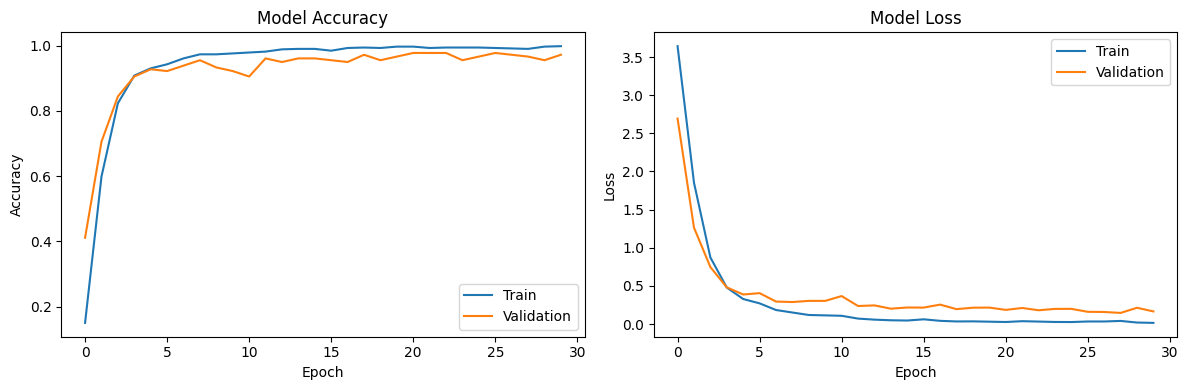

Training history telah disimpan sebagai 'gridsearch_training_history.png'


In [18]:
# Tampilkan visualisasi hyperparameter (opsional, tambahkan jika diperlukan)
import matplotlib.pyplot as plt

# Visualisasi training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.savefig('gridsearch_training_history.png')
plt.show()

print("Training history telah disimpan sebagai 'gridsearch_training_history.png'")

I0000 00:00:1754022836.677859   12805 service.cc:152] XLA service 0x7f1ff00048c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754022836.677910   12805 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2025-08-01 11:33:56.792032: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1754022837.632553   12805 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-08-01 11:33:58.738969: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1168', 8 bytes spill stores, 8 bytes spill loads



 6/45 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

I0000 00:00:1754022846.082925   12805 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


45/45 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step


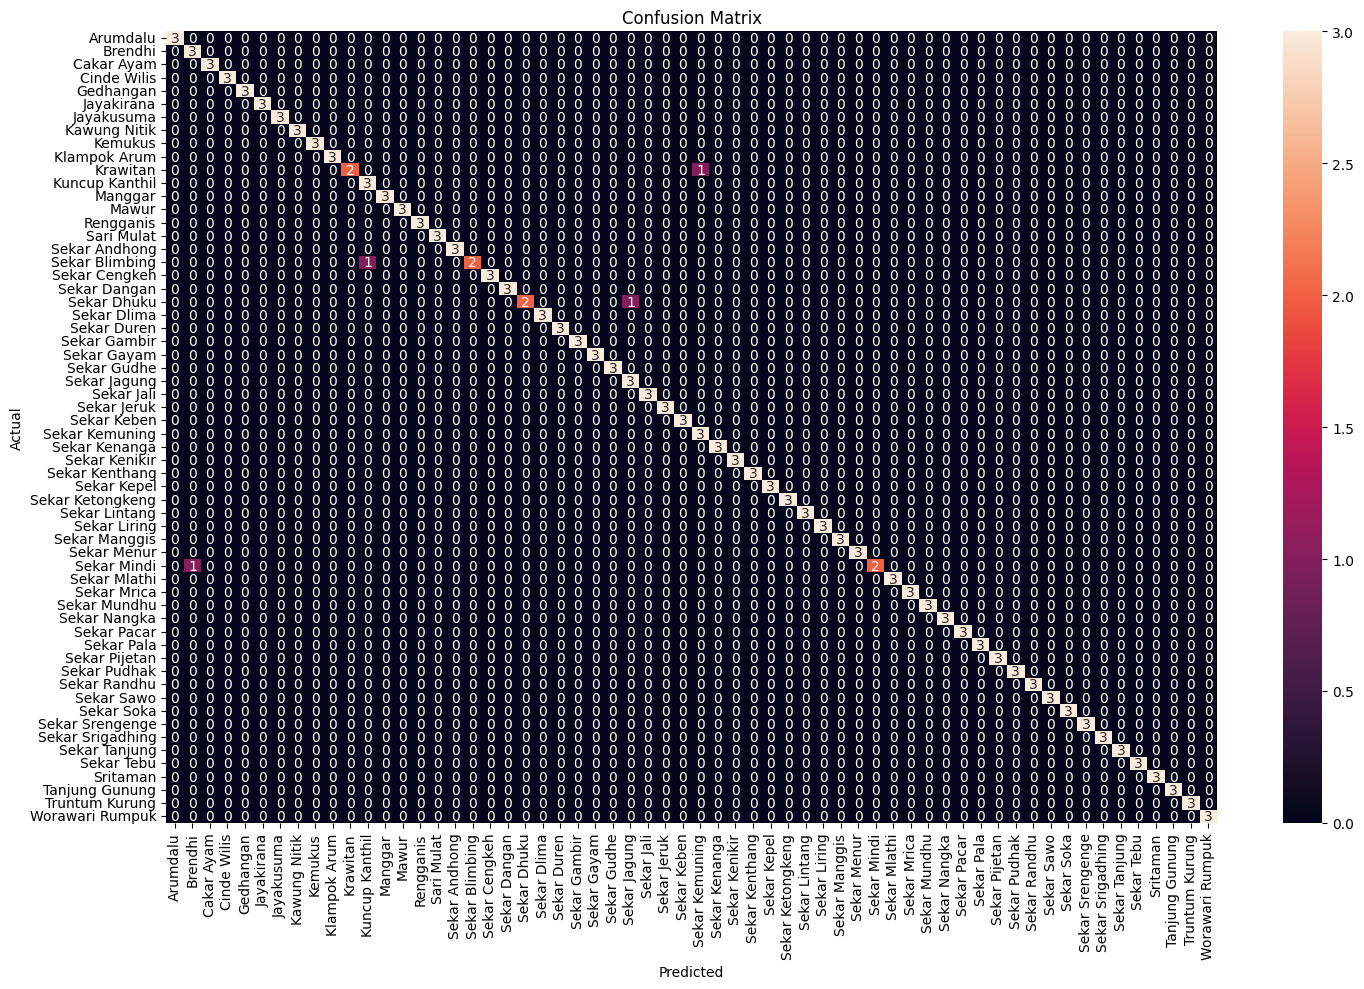

                  precision    recall  f1-score   support

        Arumdalu       1.00      1.00      1.00         3
         Brendhi       0.75      1.00      0.86         3
      Cakar Ayam       1.00      1.00      1.00         3
     Cinde Wilis       1.00      1.00      1.00         3
       Gedhangan       1.00      1.00      1.00         3
      Jayakirana       1.00      1.00      1.00         3
      Jayakusuma       1.00      1.00      1.00         3
    Kawung Nitik       1.00      1.00      1.00         3
         Kemukus       1.00      1.00      1.00         3
    Klampok Arum       1.00      1.00      1.00         3
        Krawitan       1.00      0.67      0.80         3
  Kuncup Kanthil       0.75      1.00      0.86         3
         Manggar       1.00      1.00      1.00         3
           Mawur       1.00      1.00      1.00         3
       Rengganis       1.00      1.00      1.00         3
      Sari Mulat       1.00      1.00      1.00         3
   Sekar Andh

In [12]:

model_path = '/home/nvidia/Batik-Final/src/models/hyperparameterTuning/gridSearch/best_gridsearch_model.keras'
model = tf.keras.models.load_model(model_path)
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes
class_names = test_generator.class_indices

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(15, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.savefig("confusion_matrix.png")
plt.show()

report = classification_report(y_true, y_pred_classes, target_names=class_names)
print(report)


In [19]:
# Analisis hasil GridSearch
print("\n==== ANALISIS HASIL GRIDSEARCH ====")
print("GridSearch telah mencoba semua kombinasi hyperparameter yang mungkin.")
print("Ini memberikan hasil yang lebih ekshaustif dibandingkan RandomSearch,")
print("tetapi memakan waktu yang jauh lebih lama.")

# Hitung total trials
total_trials = len(tuner.oracle.trials)
print(f"\nTotal trials yang dijalankan: {total_trials}")

# Tampilkan beberapa trial terbaik
print("\nTop 5 trials:")
for i, trial in enumerate(tuner.oracle.get_best_trials(5)):
    print(f"{i+1}. Trial {trial.trial_id} - Score: {trial.score:.4f}")
    print(f"   Hyperparameters: {trial.hyperparameters.values}")


==== ANALISIS HASIL GRIDSEARCH ====
GridSearch telah mencoba semua kombinasi hyperparameter yang mungkin.
Ini memberikan hasil yang lebih ekshaustif dibandingkan RandomSearch,
tetapi memakan waktu yang jauh lebih lama.

Total trials yang dijalankan: 10

Top 5 trials:
1. Trial 03 - Score: 0.9778
   Hyperparameters: {'add_conv_layer': True, 'conv_filters': 64, 'dense_units': 128, 'learning_rate': 0.0001, 'optimizer': 'adam'}
2. Trial 04 - Score: 0.9722
   Hyperparameters: {'add_conv_layer': True, 'conv_filters': 64, 'dense_units': 128, 'learning_rate': 0.0001, 'optimizer': 'rmsprop'}
3. Trial 06 - Score: 0.9722
   Hyperparameters: {'add_conv_layer': True, 'conv_filters': 64, 'dense_units': 256, 'learning_rate': 0.001, 'optimizer': 'adam'}
4. Trial 09 - Score: 0.9722
   Hyperparameters: {'add_conv_layer': True, 'conv_filters': 64, 'dense_units': 256, 'learning_rate': 0.0001, 'optimizer': 'adam'}
5. Trial 05 - Score: 0.9611
   Hyperparameters: {'add_conv_layer': True, 'conv_filters': 64, 

In [20]:
# =========== GRID SEARCH TIMING SUMMARY ===========

# End tracking
grid_search_end_time = time.time()
grid_search_total_time = grid_search_end_time - grid_search_start_time

print(f"⏱️  Total waktu komputasi: {grid_search_total_time:.2f} detik")
print(f"📅 Waktu selesai: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

# Save timing results
timing_results = {
    'method_name': 'Grid Search',
    'start_datetime': grid_search_start_datetime.strftime('%Y-%m-%d %H:%M:%S'),
    'end_datetime': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'total_time_seconds': grid_search_total_time,
    'total_time_minutes': grid_search_total_time / 60
}

with open('grid_search_timing_results.json', 'w') as f:
    json.dump(timing_results, f, indent=2, ensure_ascii=False)

print(f"\n📊 RINGKASAN WAKTU KOMPUTASI GRID SEARCH:")
print(f"⏱️  Total waktu: {timing_results['total_time_minutes']:.2f} menit")
print(f"📅 Mulai: {timing_results['start_datetime']}")
print(f"📅 Selesai: {timing_results['end_datetime']}")


⏱️  Total waktu komputasi: 1454.63 detik
📅 Waktu selesai: 2025-07-31 14:54:31

📊 RINGKASAN WAKTU KOMPUTASI GRID SEARCH:
⏱️  Total waktu: 24.24 menit
📅 Mulai: 2025-07-31 14:30:16
📅 Selesai: 2025-07-31 14:54:31
